In [2]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
include("../code/learn_polynomial_with_side_info.jl")

using Dates
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
using JSON
using ProgressBars
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [3]:
function get_vf_for_parameters(params)
    a1, b1, a2, b2, c1, c2 = params
    f(u1, u2) =    [-a1 * u1 + b1*(c1-u1)*u2
                    -a2 * u2 + b2*(c2-u2)*u1]
    return f
end

get_vf_for_parameters (generic function with 1 method)

Solving ODE from x0=[0.4, 0.1]
size(sol) = (2, 10001)
length = 10


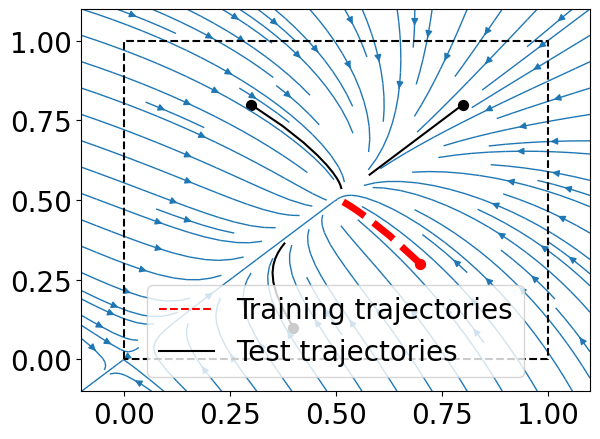

Solving ODE from x0=[0.8, 0.8]
size(sol) = (2, 10001)
length = 10
Solving ODE from x0=[0.3, 0.8]
size(sol) = (2, 10001)
length = 10
Solving ODE from x0=[0.7, 0.3]
size(sol) = (2, 10001)
length = 10


PyObject <matplotlib.legend.Legend object at 0x7f460790bf10>

In [4]:
gr(size=(600,400))


ode_p = [.05 .1 .05 .1 1. 1.]
ff = get_vf_for_parameters(ode_p)
Tf = 20.0 # T final
plot_vectorfield(ff, (-0.1, 1.1, 50), (-0.1, 1.1, 50))

initial_conditions = [ [.7, .3], [.4, .1], [.8, .8], [.3, .8]]
#initial_conditions = [rand(2) for _ in 1:10]
for x0 in initial_conditions[2:end]
    sol = solve_ode(ff, x0, tspan = (0., Tf))
    PyPlot.plot(sol..., color=:black)
    PyPlot.scatter(x0[1], x0[2], color=:black, s=50)
end

x0 = initial_conditions[1]
sol = solve_ode(ff, x0)
PyPlot.plot(sol..., color=:red, ls="--", lw=5)
PyPlot.scatter(x0[1], x0[2], color=:red, s=50)
PyPlot.plot([], [], color=:red, ls="--", label="Training trajectories")
PyPlot.plot([], [], color=:black, label="Test trajectories")
plot_box()
PyPlot.legend()


In [5]:
box_invariance(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p
   
    int_y = @set x2 >= 0 && 1 - x2 >= 0
    int_x = @set x1 >= 0 && 1 - x1 >= 0

    @constraint(model, subs(p1, x1=>0) >= 0, domain=int_x )
    @constraint(model, -subs(p1, x1=>1) >= 0, domain=int_y )
    @constraint(model, subs(p2, x2=>0) >= 0, domain=int_x )
    @constraint(model, -subs(p2, x2=>1) >= 0, domain=int_y )
end


monotonicity(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p

    Box = @set 1 - x1 >=  0 && x1 >= 0 && 1 - x2 >= 0 && x2 >= 0
    @constraint(model, differentiate(p1, x2) >= 0, domain=Box)
    @constraint(model, differentiate(p2, x1) >= 0, domain=Box)
end

equilibrium_points(model, p, x) = begin
    @constraint model p[1](0, 0) == 0
    @constraint model p[2](0, 0) == 0
end

equilibrium_points (generic function with 1 method)

In [7]:
ℓ₂(u) = begin
    u = reduce(vcat, u)
    sqrt(sum(u.^2) / size(u,1))
end
    
function get_trajectory(vf, x0, noise_level, length; verbose=true)
    Random.seed!(0)
    training_x = hcat(solve_ode(vf, x0; verbose=verbose, length=length, tspan=(0, Tf))...)'
    training_xdot = vf.(training_x[1, :], training_x[2, :])
    training_xdot = hcat(training_xdot...)
    training_xdot = training_xdot + noise_level * randn(size(training_xdot))
    training_x, training_xdot
end

function get_trajectories(vf, initial_conditions, noise_level, length; verbose=true,)
    training_x = []
    training_xdot = []
    for x0 = initial_conditions
        training_x_i, training_xdot_i = get_trajectory(vf, x0, noise_level,
            length; verbose=verbose)
        push!(training_x, training_x_i)
        push!(training_xdot, training_xdot_i)
    end
    hcat(training_x...), hcat(training_xdot...)
end


∞ = 1e9
function trajectory_error(vf, true_vf, initial_conditions; verbose=false)
    "Compute the error between vf and true_bf along trajectories starting from initial_conditions."
    penalty = u -> sum(abs.(u))
    try
        learned_x = get_trajectories(vf, initial_conditions, 0, 10, verbose=verbose)[1]
        true_x = get_trajectories(true_vf, initial_conditions, 0, 10, verbose=verbose)[1]
        ℓ₂(learned_x .- true_x)
    catch err
     ∞
    end

end

function box_error(vf, true_vf, box; verbose=false)
    "Compute the error between vf and true_bf on a discrete grid of box"
    xs = [
        range(b1, b2, length=Int((b2-b1)/dx)) for (b1, b2, dx)=box
    ]
    x = collect(Iterators.product(xs...))
    # adapt argument format for vf
    tilde = f -> (u -> f(u...))
    #mean(u) = sum(u) ./ size(u, 1)
    ℓ₂(tilde(vf).(x) .- tilde(true_vf).(x))
end

#get_trajectories(ff, initial_conditions, 0., 10)[2]
trajectory_error(ff, ff, initial_conditions, verbose=false)

0.0

In [8]:
train_model(deg, training_x, training_xdot, side_info; verbose=false) = begin
    p_opt, opt_value = 
    fit_polynomial_to_data_with_side_info(training_x, training_xdot; 
        side_info=side_info, verbose=verbose, deg=deg, regularization=0.)
    p_opt_as_f = (a, b) ->  map(pi -> pi([a,b]), p_opt)
    p_opt, p_opt_as_f
end

train_and_test_model(deg, noise_level, num_trajectories, num_samples, side_info,
    training_initial_conditions, test_initial_conditions; verbose=false) = begin
    training_x, training_xdot = get_trajectories(ff, training_initial_conditions[1:num_trajectories],
            noise_level, num_samples;
            verbose=verbose, )
    learned_vf_as_string, learned_vf = train_model(deg, training_x, training_xdot, side_info; verbose)
    box = ((-1, 1, .1), (-1, 1, .1))
    Dict(
        "side_info" => collect(keys(side_info)),
        "deg" => deg,
        "noise_level" => noise_level, 
        "num_trajectories" => num_trajectories, 
        "num_samples" =>  num_samples, 
        "box"=>box_error(learned_vf, ff, box),
        "test"=> trajectory_error(learned_vf, ff, test_initial_conditions),
        "training"=> trajectory_error(learned_vf, ff, training_initial_conditions[1:num_trajectories]),
        "learned_p" => string(learned_vf_as_string)
    )
end

train_and_test_model (generic function with 1 method)

In [9]:
training_initial_conditions = [ [.7, .3], [.4, .1], [.8, .8], [.3, .8]]
Random.seed!(0)
test_initial_conditions = [rand(2) for _ in 1:10]

10-element Vector{Vector{Float64}}:
 [0.8236475079774124, 0.9103565379264364]
 [0.16456579813368521, 0.17732884646626457]
 [0.278880109331201, 0.20347655804192266]
 [0.042301665932029664, 0.06826925550564478]
 [0.3618283907762174, 0.9732164043865108]
 [0.5858115517433242, 0.5392892841426182]
 [0.26003585026904785, 0.910046541351011]
 [0.16703619444214968, 0.6554484126999125]
 [0.5758873948500367, 0.8682787096942046]
 [0.9677995536192001, 0.7676903325581188]

In [10]:
side_info = [
    Dict(),
    Dict("equilibrium_points" => equilibrium_points),
    Dict("equilibrium_points" => equilibrium_points,
                "box_invariance" => box_invariance),
    Dict("equilibrium_points" => equilibrium_points,
        "box_invariance" => box_invariance,
        "monotonicity" => monotonicity)
]
    
deg = (2, 3, 4, 5, 6)
noise_level = (1e-3, 1e-2, 1e-1, )
num_trajectories = (1, 2, 3, 4)
num_samples = (10, 20, 40)

results = [train_and_test_model(args...,
                                training_initial_conditions,
                                test_initial_conditions; verbose=false)
                for args in tqdm(Iterators.product(deg, noise_level, num_trajectories, num_samples, side_info))];

0.0%┣                                             ┫ 0/720 [00:00<00:-36, -0s/it]
0.1%┣                                          ┫ 1/720 [00:27<Inf:Inf, InfGs/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
1.1%┣▌                                              ┫ 8/720 [00:27<46:28, 4s/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

2.1%┣█                                             ┫ 15/720 [00:28<23:30, 2s/it]
2.2%┣█                                             ┫ 16/720 [00:28<22:12, 2s/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
3.5%┣█▋                                            ┫ 25/720 [00:30<14:24, 1s/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
3.6%┣█▋                                            ┫ 26/720 [00:30<13:55, 1s/it]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
4.7%┣██▏                                           ┫ 34/720 [00:32<10:56, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
5.7%┣██▋                                           ┫ 41/720 [00:33<09:15, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

6.8%┣███▏                                          ┫ 49/720 [00:34<08:02, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
6.9%┣███▏                                          ┫ 50/720 [00:35<07:58, 1it/s]
7.1%┣███▎                                          ┫ 51/720 [00:35<07:52, 1it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
8.2%┣███▊                                          ┫ 59/720 [00:37<07:05, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

12.4%┣█████▋                                       ┫ 89/720 [00:41<04:51, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

13.9%┣██████▏                                     ┫ 100/720 [00:43<04:32, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

14.7%┣██████▌                                     ┫ 106/720 [00:44<04:20, 2it/s]
14.9%┣██████▌                                     ┫ 107/720 [00:45<04:19, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
15.0%┣██████▋                                     ┫ 108/720 [00:45<04:18, 2it/s]
15.1%┣██████▋                                     ┫ 109/720 [00:46<04:18, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
16.7%┣███████▍                                    ┫ 120/720 [00:49<04:06, 2it/s]
16

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
17.8%┣███████▉                                    ┫ 128/720 [00:50<03:53, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

18.9%┣████████▎                                   ┫ 136/720 [00:51<03:40, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
20.0%┣████████▉                                   ┫ 144/720 [00:52<03:29, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
20.8%┣█████████▏                                  ┫ 150/720 [00:53<03:21, 3it/s]
21.0%┣█████████▎                                  ┫ 151/720 [00:53<03:21, 3it/s]
21.1%┣█████████▎                                  ┫ 152/720 [00:53<03:21, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
21.2%┣█████████▍                                  ┫ 153/720 [00:54<03:20, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
22.6%┣██████████                                  ┫ 163/720 [00:56<03:13, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
24.2%┣██████████▋                                 ┫ 174/720 [00:59<03:07, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

25.0%┣███████████                                 ┫ 180/720 [01:00<03:02, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
25.1%┣███████████                                 ┫ 181/720 [01:02<03:07, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

26.0%┣███████████▍                                ┫ 187/720 [01:03<03:00, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

28.3%┣████████████▌                               ┫ 204/720 [01:05<02:46, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

29.4%┣█████████████                               ┫ 212/720 [01:07<02:40, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

31.4%┣█████████████▉                              ┫ 226/720 [01:09<02:31, 3it/s]
31.5%┣█████████████▉                              ┫ 227/720 [01:09<02:31, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
31.7%┣██████████████                              ┫ 228/720 [01:10<02:31, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
33.1%┣██████████████▌                             ┫ 238/720 [01:12<02:27, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

34.2%┣███████████████                             ┫ 246/720 [01:13<02:22, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

35.0%┣███████████████▍                            ┫ 252/720 [01:14<02:17, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

36.1%┣████████████████                            ┫ 260/720 [01:15<02:13, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
36.2%┣████████████████                            ┫ 261/720 [01:15<02:13, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
37.1%┣████████████████▎                           ┫ 267/720 [01:16<02:09, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
38.6%┣█████████████████                           ┫ 278/720 [01:18<02:05, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

39.6%┣█████████████████▍                          ┫ 285/720 [01:19<02:02, 4it/s]
39.7%┣█████████████████▌                          ┫ 286/720 [01:20<02:02, 4it/s]
39.9%┣█████████████████▌                          ┫ 287/720 [01:20<02:01, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
40.0%┣█████████████████▋                          ┫ 288/720 [01:21<02:01, 4it/s]
40.1%┣█████████████████▋                          ┫ 289/720 [01:21<02:01, 4it/s]
40.3%┣█████████████████▊                          ┫ 290/720 [01:21<02:01, 4it/s]
40.4%┣█████████████████▉                          ┫ 291/720 [01:22<02:01, 4it/s]
40.6%┣█████████████████▉                          ┫ 292/720 [01:22<02:01, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBa

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
42.5%┣██████████████████▊                         ┫ 306/720 [01:26<01:56, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

45.3%┣████████████████████                        ┫ 326/720 [01:29<01:47, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
46.8%┣████████████████████▋                       ┫ 337/720 [01:31<01:44, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
46.9%┣████████████████████▋                       ┫ 338/720 [01:31<01:44, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
47.9%┣█████████████████████                       ┫ 345/720 [01:33<01:41, 4it/s]
48.1%┣█████████████████████▏                      ┫ 346/720 [01:33<01:41, 4it/s]
48.2%┣█████████████████████▏                      ┫ 347/720 [01:33<01:41, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
49.4%┣█████████████████████▊                      ┫ 356/720 [01:36<01:38, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

50.6%┣██████████████████████▎                     ┫ 364/720 [01:49<01:47, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

51.8%┣██████████████████████▉                     ┫ 373/720 [01:50<01:43, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

58.3%┣█████████████████████████▊                  ┫ 420/720 [02:06<01:30, 3it/s]
58.5%┣█████████████████████████▊                  ┫ 421/720 [02:07<01:30, 3it/s]
58.6%┣█████████████████████████▉                  ┫ 422/720 [02:07<01:30, 3it/s]
58.8%┣█████████████████████████▉                  ┫ 423/720 [02:07<01:30, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

60.1%┣██████████████████████████▌                 ┫ 433/720 [02:09<01:26, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
62.5%┣███████████████████████████▌                ┫ 450/720 [02:14<01:20, 3it/s]
62.6%┣███████████████████████████▋                ┫ 451/720 [02:14<01:20, 3it/s]
62.8%┣███████████████████████████▋                ┫ 452/720 [02:14<01:20, 3it/s]
62.9%┣███████████████████████████▊                ┫ 453/720 [02:15<01:20, 3it/s]
63.1%┣███████████████████████████▊                ┫ 454/720 [02:15<01:19, 3it/s]
63.2%┣███████████████████████████▉                ┫ 455/720 [02:16<01:19, 3it/s]
63.3%┣███████████████████████████▉                ┫ 456/720 [02:16<01:19, 3it/s]
63.5%┣████████████████████████████                ┫ 457/720 [02:16<01:19, 3it/s]
63.6%┣████████████████████████████                ┫ 458/720 [02:17<01:18, 3it/s]
63.7%┣████████████████████████████                ┫ 459/720 [02:17<01:18, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /ho

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

68.6%┣██████████████████████████████▏             ┫ 494/720 [02:28<01:08, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

71.2%┣███████████████████████████████▍            ┫ 513/720 [02:34<01:02, 3it/s]
71.4%┣███████████████████████████████▍            ┫ 514/720 [02:34<01:02, 3it/s]
71.5%┣███████████████████████████████▌            ┫ 515/720 [02:35<01:02, 3it/s]
71.7%┣███████████████████████████████▌            ┫ 516/720 [02:35<01:01, 3it/s]
71.8%┣███████████████████████████████▋            ┫ 517/720 [02:36<01:01, 3it/s]
71.9%┣███████████████████████████████▋            ┫ 518/720 [02:36<01:01, 3it/s]
72.1%┣███████████████████████████████▊            ┫ 519/720 [02:36<01:01, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Abortin

78.6%┣██████████████████████████████████▋         ┫ 566/720 [02:55<00:48, 3it/s]
78.8%┣██████████████████████████████████▋         ┫ 567/720 [02:55<00:47, 3it/s]
78.9%┣██████████████████████████████████▊         ┫ 568/720 [02:55<00:47, 3it/s]
79.0%┣██████████████████████████████████▊         ┫ 569/720 [02:56<00:47, 3it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

88.5%┣███████████████████████████████████████     ┫ 637/720 [03:22<00:26, 3it/s]
88.6%┣███████████████████████████████████████     ┫ 638/720 [03:22<00:26, 3it/s]
88.8%┣███████████████████████████████████████     ┫ 639/720 [03:23<00:26, 3it/s]
88.9%┣███████████████████████████████████████▏    ┫ 640/720 [03:23<00:25, 3it/s]
89.0%┣███████████████████████████████████████▏    ┫ 641/720 [03:23<00:25, 3it/s]
89.2%┣███████████████████████████████████████▎    ┫ 642/720 [03:24<00:25, 3it/s]
89.3%┣███████████████████████████████████████▎    ┫ 643/720 [03:24<00:24, 3it/s]
89.4%┣███████████████████████████████████████▍    ┫ 644/720 [03:25<00:24, 3it/s]
89.6%┣███████████████████████████████████████▍    ┫ 645/720 [03:25<00:24, 3it/s]
89.7%┣███████████████████████████████████████▌    ┫ 646/720 [03:26<00:24, 3it/s]
89.9%┣███████████████████████████████████████▌    ┫ 647/720 [03:26<00:23, 3it/s]
90.0%┣███████████████████████████████████████▋    ┫ 648/720 [03:26<00:23, 3it/s]
90.1%┣██████████████████████

98.3%┣███████████████████████████████████████████▎┫ 708/720 [03:49<00:04, 3it/s]
98.5%┣███████████████████████████████████████████▎┫ 709/720 [03:50<00:04, 3it/s]
98.6%┣███████████████████████████████████████████▍┫ 710/720 [03:51<00:03, 3it/s]
98.8%┣███████████████████████████████████████████▌┫ 711/720 [03:51<00:03, 3it/s]
98.9%┣███████████████████████████████████████████▌┫ 712/720 [03:51<00:03, 3it/s]
99.0%┣███████████████████████████████████████████▋┫ 713/720 [03:52<00:02, 3it/s]
99.2%┣███████████████████████████████████████████▋┫ 714/720 [03:52<00:02, 3it/s]
99.3%┣███████████████████████████████████████████▊┫ 715/720 [03:53<00:02, 3it/s]
99.4%┣███████████████████████████████████████████▊┫ 716/720 [03:53<00:01, 3it/s]
99.6%┣███████████████████████████████████████████▉┫ 717/720 [03:54<00:01, 3it/s]
99.7%┣███████████████████████████████████████████▉┫ 718/720 [03:54<00:01, 3it/s]
99.9%┣████████████████████████████████████████████┫ 719/720 [03:54<00:00, 3it/s]
100.0%┣█████████████████████

In [11]:
date_now = Dates.format(now(),"yyyy-mm-dd--HH-MM")
open("../data/disease-table/results-$(date_now).json","w") do f 
    JSON.print(f, results, 4)
end

In [10]:
?JSON.print(S)

No documentation found.

`JSON.Writer.print` is a `Function`.

```
# 4 methods for generic function "print":
[1] print(io::IO, obj) in JSON.Writer at /home/user/.julia/packages/JSON/QXB8U/src/Writer.jl:349
[2] print(io::IO, obj, indent) in JSON.Writer at /home/user/.julia/packages/JSON/QXB8U/src/Writer.jl:347
[3] print(a) in JSON.Writer at /home/user/.julia/packages/JSON/QXB8U/src/Writer.jl:352
[4] print(a, indent) in JSON.Writer at /home/user/.julia/packages/JSON/QXB8U/src/Writer.jl:351
```
